In [458]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
plt.style.use('bmh')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
from IPython.core.display import display, HTML
pylab.rcParams.update(params)
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', None)
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lars
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import statsmodels.api as sm
import statsmodels.api 

In [459]:
df = pd.read_csv("ml_dataset.csv")
df['Date'] =  pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df.shape

(2366, 110)

In [460]:
to_stationary = ['S&P_Open', 'S&P_High', 'S&P_Low', 'S&P_Close', 'S&P_Volume', 'CO_Close', 'RBOB_f__Open', 'RBOB_f__High', 'RBOB_f__Low', 'RBOB_f__Close', 'RBOB_f__Volume', 'RBOB_f__OpenInt', 'RBOB_minus_CO']

### Adding stationary variables

In [461]:
df_stationary = df.copy()
df_stationary = df_stationary[to_stationary].diff()
df_stationary.dropna(inplace = True)
df_stationary = df_stationary.add_prefix("Stationary_")
df = pd.merge(df,df_stationary,left_index=True,right_index=True,how="inner")
df.shape

(2365, 123)

In [462]:
df_train_val = df[df.index<="2018-11-29"]
df_test = df[df.index>"2018-11-29"]
df_train = df_train_val[df_train_val.index<="2017-11-29"]
df_val = df_train_val[df_train_val.index>"2017-11-29"]

### Vanila LSTM preparation 

In [463]:
# variables = ['RBOB_f__Close', 'y_shif1', 'rolling_mean_week', 'rolling_mean_2days', 'rolling_mean_3days', 'RBOB_f_DEMA', 'RBOB_f_MIDPOINT', 'RBOB_f_SMA', 'RBOB_f_T3', 'RBOB_f_TEMA','y']
variables = df.columns.tolist()
variables.remove("y")
features = df_train[variables].columns
target = 'y'
print(len(features))

122


In [464]:
from sklearn.preprocessing import MinMaxScaler

sf = MinMaxScaler()
st = MinMaxScaler()
x_train = sf.fit_transform(df_train[features].values)
y_train = st.fit_transform((df_train[target].values).reshape(-1,1))
y_train = y_train.ravel()

x_val = sf.transform(df_val[features])
y_val = st.fit_transform((df_val[target].values).reshape(-1,1))
y_val = y_val.ravel()

print(x_train.shape,x_val.shape)
print(y_train.shape,y_val.shape)

(1861, 122) (252, 122)
(1861,) (252,)


In [465]:
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_val = x_val.reshape(x_val.shape[0], 1, x_val.shape[1])

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1861, 1, 122) (1861,) (252, 1, 122) (252,)


In [476]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed

In [487]:
# design network
model = Sequential()

model.add((LSTM(units = 100, input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=False)))
# model.add(Dropout(0.2))

# model.add(LSTM(units=100, return_sequences=False))
# model.add(Dropout(0.2))

# model.add(LSTM(units=64, return_sequences=True,activation="relu"))
# model.add(Dropout(0.2))

# model.add(LSTM(units=64,activation="relu"))
# model.add(Dropout(0.2))

model.add((Dense(units=1)))

In [488]:
model.compile(loss='mse', optimizer='adam')

In [491]:
# fit network
history = model.fit(x_train, y_train, epochs=10, batch_size=None, validation_data=(x_val, y_val), verbose=1, shuffle=False,steps_per_epoch=200,validation_steps=50)

Train on 1861 samples, validate on 252 samples
Epoch 1/10
200/200 [==============================] - 6s 28ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 4.5510e-04 - val_loss: 0.0016
Epoch 3/10
200/200 [==============================] - 5s 24ms/step - loss: 3.9866e-04 - val_loss: 0.0015
Epoch 4/10
200/200 [==============================] - 5s 24ms/step - loss: 3.7276e-04 - val_loss: 0.0015
Epoch 5/10
200/200 [==============================] - 5s 24ms/step - loss: 3.5814e-04 - val_loss: 0.0015
Epoch 6/10
200/200 [==============================] - 5s 24ms/step - loss: 3.4706e-04 - val_loss: 0.0015
Epoch 7/10
200/200 [==============================] - 5s 24ms/step - loss: 3.3726e-04 - val_loss: 0.0015
Epoch 8/10
200/200 [==============================] - 5s 24ms/step - loss: 3.2820e-04 - val_loss: 0.0015
Epoch 9/10
200/200 [==============================] - 5s 24ms/step - loss: 3.1983e-04 - val_loss: 0.0015
Epoch 10/10


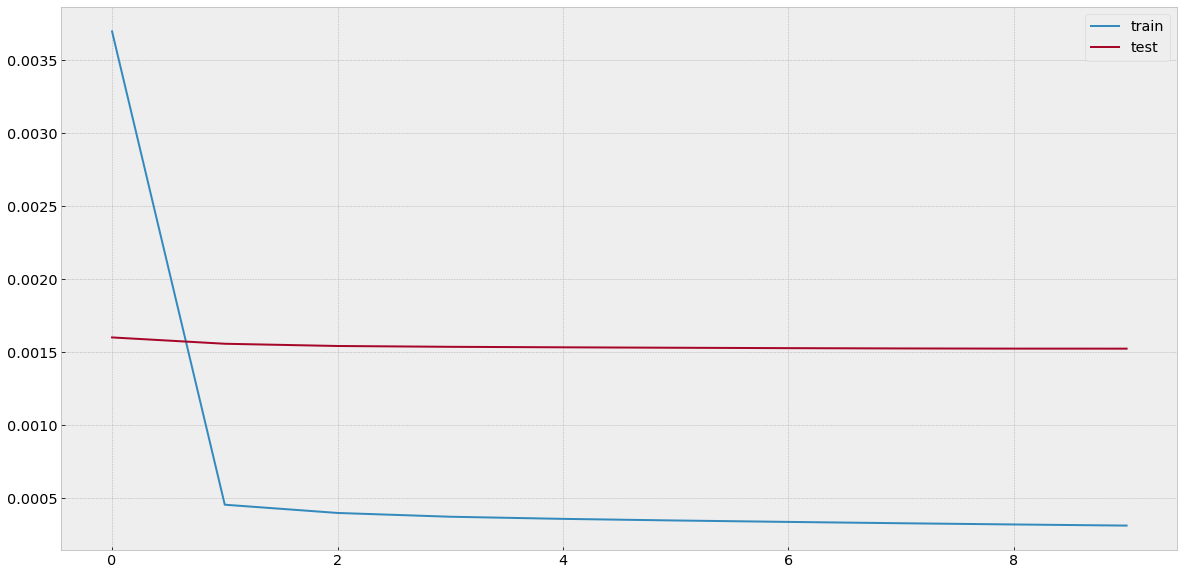

In [492]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [493]:
# make a prediction
yhat = st.inverse_transform(model.predict(x_val))

C:\Users\wozni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


RMSE:  0.24374773524671275


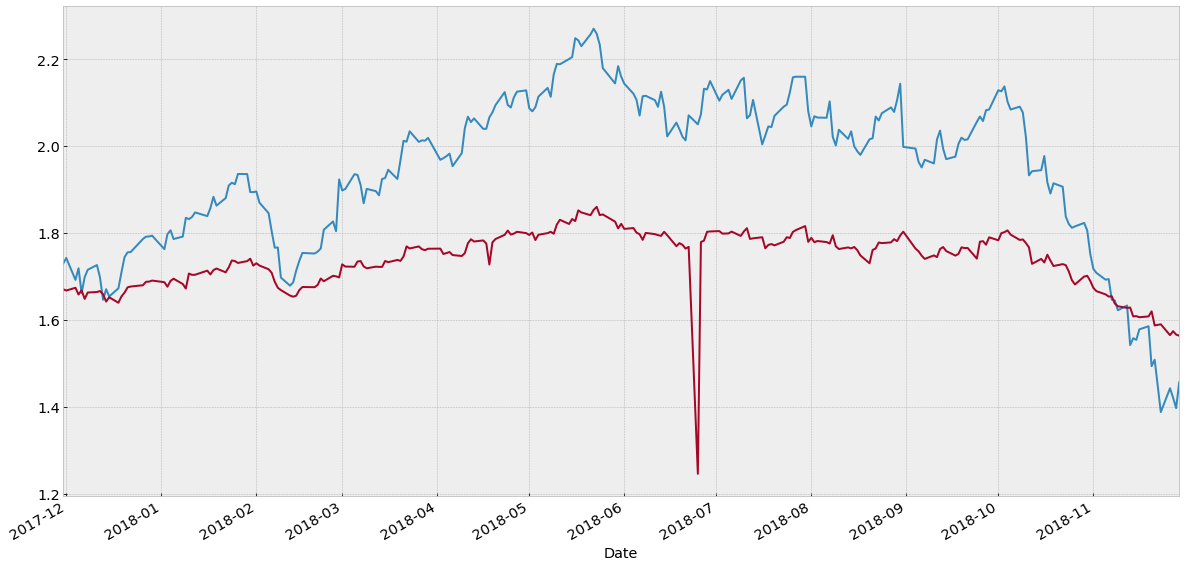

In [494]:
dF = df_val
dF["y_hat"] = yhat
dF["y"].plot()
dF["y_hat"].plot()
print("RMSE: ",statsmodels.tools.eval_measures.rmse(dF.y,dF.y_hat))

In [495]:
from sklearn.metrics import *

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adj_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+y_pred))) * 100

def metryczki(x,y):
    wyniki = pd.DataFrame()
    mae = mean_absolute_error(x,y)
    xd = list()
    xd.append(mae)
    mse = mean_squared_error(x,y)
    rmse = np.sqrt(mean_squared_error(x,y))
    mape = mean_absolute_percentage_error(x,y)
    amape = adj_mean_absolute_percentage_error(x,y)
    wyniki["MAE"]=xd
    wyniki["MSE"]=mse
    wyniki["RMSE"]=rmse
    wyniki["MAPE"]=mape
    wyniki["AMAPE"]=amape
    return wyniki

In [496]:
metryczki(df_val[target], yhat)

,MAE,MSE,RMSE,MAPE,AMAPE
0,0.216675,0.059413,0.243748,12.254798,6.572638


# LSTM FAILED :( 